### Implementation of UKF for Quadcopter dynamics

We use the full quadrotor state dynamics with state
 $$[x, \dot x, q, \dot \omega]$$

And inputs 
$$[f_T, \tau]$$

In [ ]:
from scipy.spatial.transform import Rotation 
from scipy.stats import chi2
import numpy as np
import copy 

#TODO: Modify dynamics function so that it works with a batch of points. i.e., input has shape (L, 2L + 1)
# Should mostly have to change the skew symmetric omega matrix and the cross product operation.

# Matrix to quaternion: Rotation.from_matrix(rotation_matrix).as_quat()
# Quaternion to matrix: Rotation.from_quat(quaternion).as_matrix() 


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


"\nApproach: \n    1. We use the full quad dynamics. \n    2. Inputs are thrust and moments. \n    3. These don't actually matter for the estimator as they'll be modeled as noise and we don't have access to them. \n    4. If we want to test the estimator with a toy example before gazebo, we can ask chatGPT to generate a thrust and moment control \n    law for a simple back and forth trajectory and code to plot accs, vels, and pos from that. \n    5. That means our process noise vector has size 2, because of our two inputs. \n    6. (Optional) Before trying to implement the augmented noise step, try the additive following the old hw solution.\n    7. When running the gazebo simulation we give the same trajectory generator commands as acceleration, this actually doesn't matter, \n    as the PX4 cascated PID controller gives thrust and moment commands at the lowest level. \n\n"

In [80]:
class Quad():
    def __init__(self, x0, dt, m=2.5, d=0.35):
        """
        Constructor for Quadcopter

        Inputs: 
            - x0, true state initial state, (13, 1) nd.array 
            - dt, discretized time interval, 30 for gazebo sim, float. 
            - Quad mass, about 2.5 Kg for x500 model, float.
            - Quad arm length, about 0.35 m for x500 model, float.
        """
        self.dt = dt
        self.m = m 
        self.d = d
        self.g = 9.81 # m/s^2
        self.I = np.eye(3)
        self.I[0, 0] = m * (d ** 2)
        self.I[1, 1] = m * (d ** 2) 
        self.I[2, 2] = 0.5 * m * (d ** 2)
        self.L = x0.shape[0]

        self.x = copy.deepcopy(x0) 

        # state and control history (h for history not hat)
        self.xh = [copy.deepcopy(x0)]
        self.uh = [] 

        # Measurement noise for position measurement (simulate lidar) 
        self.R = np.diag([1e-2, 1e-2, 1e-2]) #TODO Try experimenting with this value

    def W(self, u, alphas=[0.1, 0.01, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1]):
        """
        Process noise. 
        You could implement a model that adds more noise the faster 
        the vehicle is thrusting and the higher the moments, but for now
        let's just make it a fixed variance for each.

        Here thrust and moments have the same effect on each other's uncertainties
        (that's what the noise characteristics, alpha, are). But you could modify this 
        to something that makes more sense. 
        Perhaps thrust should be noisier if yaw is high.  
        """

        # This adds noise of scale 10^2 which is way off
        # var1 = alphas[0] * u[0] ** 2 + alphas[1] * u[1] ** 2 + alphas[2] * u[2] ** 2 + alphas[3] * u[3] ** 2
        # var2 = alphas[4] * u[0] ** 2 + alphas[5] * u[1] ** 2 + alphas[6] * u[2] ** 2 + alphas[7] * u[3] ** 2

        # If hover thrust is about 2.5 * 9.81 ~ 25 N, then var1 ~ 0.1
        # If moments are about m * d ** 2 * alpha ~ 2.5 * 0.111 * 0.75 ~ 0.2, then var2 ~ 0.01
        var1 = 0.1
        var2 = 0.01
        cov = np.eye(4)
        cov[0, 0] = var1
        cov[1, 1] = var2 
        cov[2, 2] = var2
        cov[3, 3] = var2

        return cov

    def f(self, xk, uk, dt):
        """
        Dynamics model for the drone. 
        Propagates state from k to k + 1 

        Inputs: 
            - State, x, at k, nd.array(13, 1) 
            - Control law, u, at k, total thrust and moment along each euler angle, nd.array (4, 1)
            - dt, discrete timestep 
        Output: 
            - xkp1, propagated state
        """

        # Extract state
        pk = xk[:3, :]
        vk = xk[3:6, :]
        qk = xk[6:10, :]
        omk = xk[10:13, :]

        # Check for zero norm quaternions 
        if np.linalg.norm(qk) < 1e-6:
            print("WARNING: qk has near-zero norm!", qk.T)

        # Extract inputs
        Tk = uk[0, :].reshape(1, 1)
        tauk = uk[1:, :]

        # Compute drone's acceleration at k 
        e3 = np.array([[0, 0, -1]]).T
        zb = np.array([[0, 0, 1]]).T
        
        q_roll = np.roll(qk.flatten(), -1)
        q_roll /= np.linalg.norm(q_roll) # Normalize and roll quaternion (avoid zero norm, and change to scalar last format)
        Rk = Rotation.from_quat(q_roll).as_matrix()
        ak = self.g * e3 + Rk @ zb * Tk / self.m 

        # Propagate translational dynamics 
        pkp1 = pk + vk * dt 
        vkp1 = vk + ak * dt 

        # Compute skew-symmetric omega matrix 
        wx, wy, wz = omk[0, 0], omk[1, 0], omk[2, 0]
        Omk = np.array([[ 0, -wx, -wy, -wz], # This choice of skey symmetric matrix requires scalar first quaternion convention 
                        [wx,   0,  wz, -wy],
                        [wy, -wz,   0,  wx],
                        [wz,  wy,  -wx,  0]])

        # Propagate rotational dynamics 
        # qkp1 = qk + 0.5 * Omk @ qk * dt # NOTE: scipy method is more stable than this
        rot = Rotation.from_quat(np.roll(qk.flatten(), -1)) 
        delta_rot = Rotation.from_rotvec(omk.flatten() * dt)        
        new_rot = delta_rot * rot
        qkp1 = np.roll(new_rot.as_quat(), 1).reshape(4, 1)   
        qkp1 = qkp1 / np.linalg.norm(qkp1) 
        omega = omk.reshape(3,) # Required for cross product
        omkp1 = omk + np.linalg.inv(self.I) @ (tauk + np.cross(omega, self.I @ omega).reshape(3, 1)) * dt

        # Construct propagated state vector 
        xkp1 = np.vstack((pkp1, vkp1, qkp1, omkp1))

        return xkp1 

    def h(self, xk):
        """
        Measurement model for lidar sensor 

        Inputs: 
            - xk, current state
        Outputs: 
            - Current position, nd.array (3, 2L + 1)
        """
        return xk[:3, :]

    def move(self, uk):
        """
        Simple physics simulation of the quadcopter 

        Inputs: 
            - uk, the control law at timestep k, nd.array (4, 1) 
        """

        # Add process noise to the desired commands 
        uk_noisy = np.random.multivariate_normal(uk[:, 0], self.W(uk)).reshape(4, 1)

        # Propagate state forward
        self.x = self.f(self.x.reshape(self.L, 1), uk_noisy, self.dt)

        # Keep history 
        self.uh.append(copy.deepcopy(uk_noisy))
        self.xh.append(copy.deepcopy(self.x))

    def sense(self):
        """
        Simulate lidar sensor reading by adding noise to measurement

        Inputs: 
            - None, uses class variable self.x

        Outputs: 
            - noised up measurement
        """

        # Get measurement from measurement model 
        pk_mes = self.h(self.x)

        # Add noise to the reading  
        return np.random.multivariate_normal(pk_mes[:, 0], self.R).reshape(3, 1)


In [81]:
class UKF():
    def __init__(self, quad, x0, Q0, alpha=1e-3, beta=2, kappa=0):
        """
            Unscented Kalman Filter 
            
            Inputs:
                - quad model 
                - x0, initial state
                - Q0, initial covariance 
                - alpha, determines spread of sigma points distribution around mean state, usually 1e-3.
                - beta, incorporates prior knowledge to distribution, optimally 2 for Gaussians. 
                - Kappa, secondary scaling parameter, usually zero. 
        """
        # UT Params 
        self.kappa = kappa
        self.L = x0.shape[0]
        self.alpha = alpha 
        self.beta = beta 
        self.lamb = self.alpha ** 2 * (self.L + self.kappa) - self.L 

        # Initialize filter state and covariance 
        self.xhat = copy.deepcopy(x0)
        self.Q = copy.deepcopy(Q0)

        # Initialize filter state and covariance history 
        self.xhath = [copy.deepcopy(x0)]
        self.Qh = [copy.deepcopy(Q0)]

        # Save quad model instance as a class variable for dynamics 
        self.quad = quad

        # Dynamics and measurement models (assume we have perfect model knowledge) 
        self.f = quad.f 
        self.h = quad.h

        # Model noise as either a function of control or just even noise 
        even_noise = True 
        if even_noise: 
            # self.W = np.diag([1e-6, 1e-6, 1e-6, 1e-3, 1e-3, 1e-3, 1e-5, 1e-5, 1e-5, 1e-5, 1e-4, 1e-4, 1e-4]) # vel 1.0 
            self.W = np.diag([1e-4, 1e-4, 1e-3, 1e-1, 1e-1, 1e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]) # vel 3.0
            self.R = quad.R
        else:
            self.W = quad.W 
            self.R = quad.R 

    def filter_UT(self, y_mes, ubar):
        """ 
            Apply Unscented Kalman Filter 

            Inputs: 
                - y_mes, measurement from quad simulation, nd.array(3, 1)
                - ubar, mean input control law since we don't have the actual control inputs, nd.array(4, 1)
        """

        # Compute weights 
        Wm = np.zeros((2 * self.L + 1, 1))
        Wm[0, :] = self.lamb / (self.L + self.lamb)
        Wm[1:, :] = 1 / (2 * (self.L + self.lamb)) 

        Wc = np.zeros((2 * self.L + 1, 1))
        Wc[0, :] = self.lamb / (self.L + self.lamb) + (1 - self.alpha ** 2 + self.beta) 
        Wc[1:, :] = Wm[1:, :] 
        
        # Compute sigma points 
        sqrtQ = np.linalg.cholesky((self.L + self.lamb) * self.Q + 1e-9 * np.eye(self.L))
        Xk = np.zeros((2 * self.L + 1, self.L))
        Xk[0, :] = self.xhat[:, 0]
        Xk[1:self.L+1, :] = self.xhat[:, 0] + sqrtQ.T
        Xk[self.L+1:, :] = self.xhat[:, 0] - sqrtQ.T

        # Push sigma points through dynamics and recover state at k+1
        Xkp1 = np.array([self.f(Xk[i, :].reshape(self.L, 1), ubar, self.quad.dt).flatten() for i in range(2 * self.L + 1)]).reshape((2 * self.L + 1, self.L))
        Quat = Xkp1[:, 6:10]                 
        norms = np.linalg.norm(Quat, axis=1, keepdims=True) # Normalize quaternion sigma points along the manifold to prevent spikes  
        Xkp1[:, 6:10] = Quat / norms          
        self.xhat = np.sum(Wm * Xkp1, axis=0).reshape(-1, 1)

        # Recover state covariance at k_1 
        self.Q = (Wc * (Xkp1 - self.xhat.T)). T @ (Xkp1 - self.xhat.T) + self.W 

        # Recompute sigma points for measurement
        sqrtQ = np.linalg.cholesky((self.L + self.lamb) * self.Q + 1e-9 * np.eye(self.L))
        Xk = np.zeros((2 * self.L + 1, self.L))
        Xk[0, :] = self.xhat[:, 0]
        Xk[1:self.L+1, :] = self.xhat[:, 0] + sqrtQ.T
        Xk[self.L+1:, :] = self.xhat[:, 0] - sqrtQ.T

        # Push sigma points through measurement model and recover mean at k+1
        Ykp1 = self.h(Xk.T).T 
        ykp1 = np.sum(Wm * Ykp1, axis=0).reshape(-1, 1)

        # Recover y covariance at k+1
        Qy_kp1 = (Wc * (Ykp1 - ykp1.T)).T @ (Ykp1 - ykp1.T) + self.R

        # Compute xy cross covariance at k+1 
        Qxy_kp1 =  (Wc * (Xkp1 - self.xhat.T)).T @ (Ykp1 - ykp1.T) 

        # Compute Kalman gain and perform measurement update 
        Kappa = Qxy_kp1 @ np.linalg.inv(Qy_kp1) 
        self.xhat += Kappa @ (y_mes - ykp1)
        self.xhat[6:10, :] = self.xhat[6:10, :] / np.linalg.norm(self.xhat[6:10, :]) # Normalize predicted quaternion to prevent spikes
        self.Q -= Kappa @ Qy_kp1 @ Kappa.T  

    def filter(self, y_mes, uk, use_input=False):
        """
        Wrapper function to keep track of estimate and covariance history
        """
        # if we have access to input contorl law use it
        if use_input: 
            u = uk
        else: 
            # Create noise input control law about hover condition 
            ubar = np.zeros((4, 1))
            ubar[0, 0] = self.quad.m * self.quad.g
            u = ubar

        # Run filter 
        self.filter_UT(y_mes, u)

        # Keep history
        self.xhath.append(copy.deepcopy(self.xhat))
        self.Qh.append(copy.deepcopy(self.Q))





In [82]:
def policy(t, m=2.5, g=9.81):
    """
    Control law for a quadrotor that flies forward 5 meters and then back to origin.

    Inputs:
        - t: time (float)
        - m: mass of the quadrotor (kg)
        - g: gravitational acceleration (m/s^2)
        
    Outputs:
        - u: control input [T, tau_x, tau_y, tau_z], shape (4, 1)
    """
    # Trapezoidal profile parameters
    a = 2.5                # max acceleration (m/s^2)
    v_max = 3.0            # max velocity (m/s)
    d = 5.0                # distance to travel (m)

    t_acc = v_max / a      # time to accelerate to v_max
    d_acc = 0.5 * a * t_acc**2
    t_flat = (d - 2 * d_acc) / v_max  # time at constant v
    t_segment = 2 * t_acc + t_flat    # time for forward or backward motion
    t_total = 2 * t_segment           # full out-and-back duration

    # Determine current phase (forward or backward)
    if t < 0:
        ax = 0.0
    elif t < t_acc:
        ax = a  # accelerating forward
    elif t < t_acc + t_flat:
        ax = 0  # constant velocity
    elif t < t_segment:
        ax = -a  # decelerating forward
    elif t < t_segment + t_acc:
        ax = -a  # accelerating backward
    elif t < t_segment + t_acc + t_flat:
        ax = 0   # constant velocity backward
    elif t < t_total:
        ax = a   # decelerating backward
    else:
        ax = 0.0  # hover at origin

    # Thrust: compensate for gravity + needed horizontal acceleration
    # Assuming thrust vector stays vertical (no roll/pitch), total thrust = mass * g
    # To truly accelerate forward, the drone would pitch, but we're assuming simplified flat dynamics
    T = m * g / np.cos(np.arctan2(ax, g))  # slightly more accurate than T = m * sqrt(g^2 + ax^2)

    # Torques are zero (assume PD controller handles small pitch changes)
    tau = np.zeros((3, 1))

    return np.vstack(([[T]], tau))

### Example 1: Fly in a straight line.

In this example the UKF measures position and has access to the total thrust and moment control law.
While it can use the input to predict the orientation and angular rates of the quadrotor, it has no orientation feedback 
(as yaw isn't observable from position) and so it cannot correct for drifts in orientation. 

In [83]:
# Simulate quad for a back and forth trajectory in x 
dt = 0.1
# time = np.arange(0, 10+dt, dt)
time = np.linspace(0, 10, int(10 / dt) )

# Initial conditions 
Q0 = np.diag([1e-6, 1e-6, 1e-6, 1e-3, 1e-3, 1e-3, 1e-5, 1e-5, 1e-5, 1e-5, 1e-4, 1e-4, 1e-4])
x0 = np.array([[0., 0., 1.5, 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,]]).T # p: 0, 0, 1.5; v: 0, 0, 0; q: 1, 0, 0, 0; omega: 0, 0, 0

# Initialize quad and ukf
quad = Quad(x0, dt)
ukf = UKF(quad, x0, Q0)

In [84]:
for t in time: 
    # Generate policy for simulation 
    u = policy(t)

    # Simulate quad
    # print(f"Shape of u: {u.shape}")
    quad.move(u)
    y_mes = quad.sense()

    # Run UKF 
    ukf.filter(y_mes, u, use_input=True)

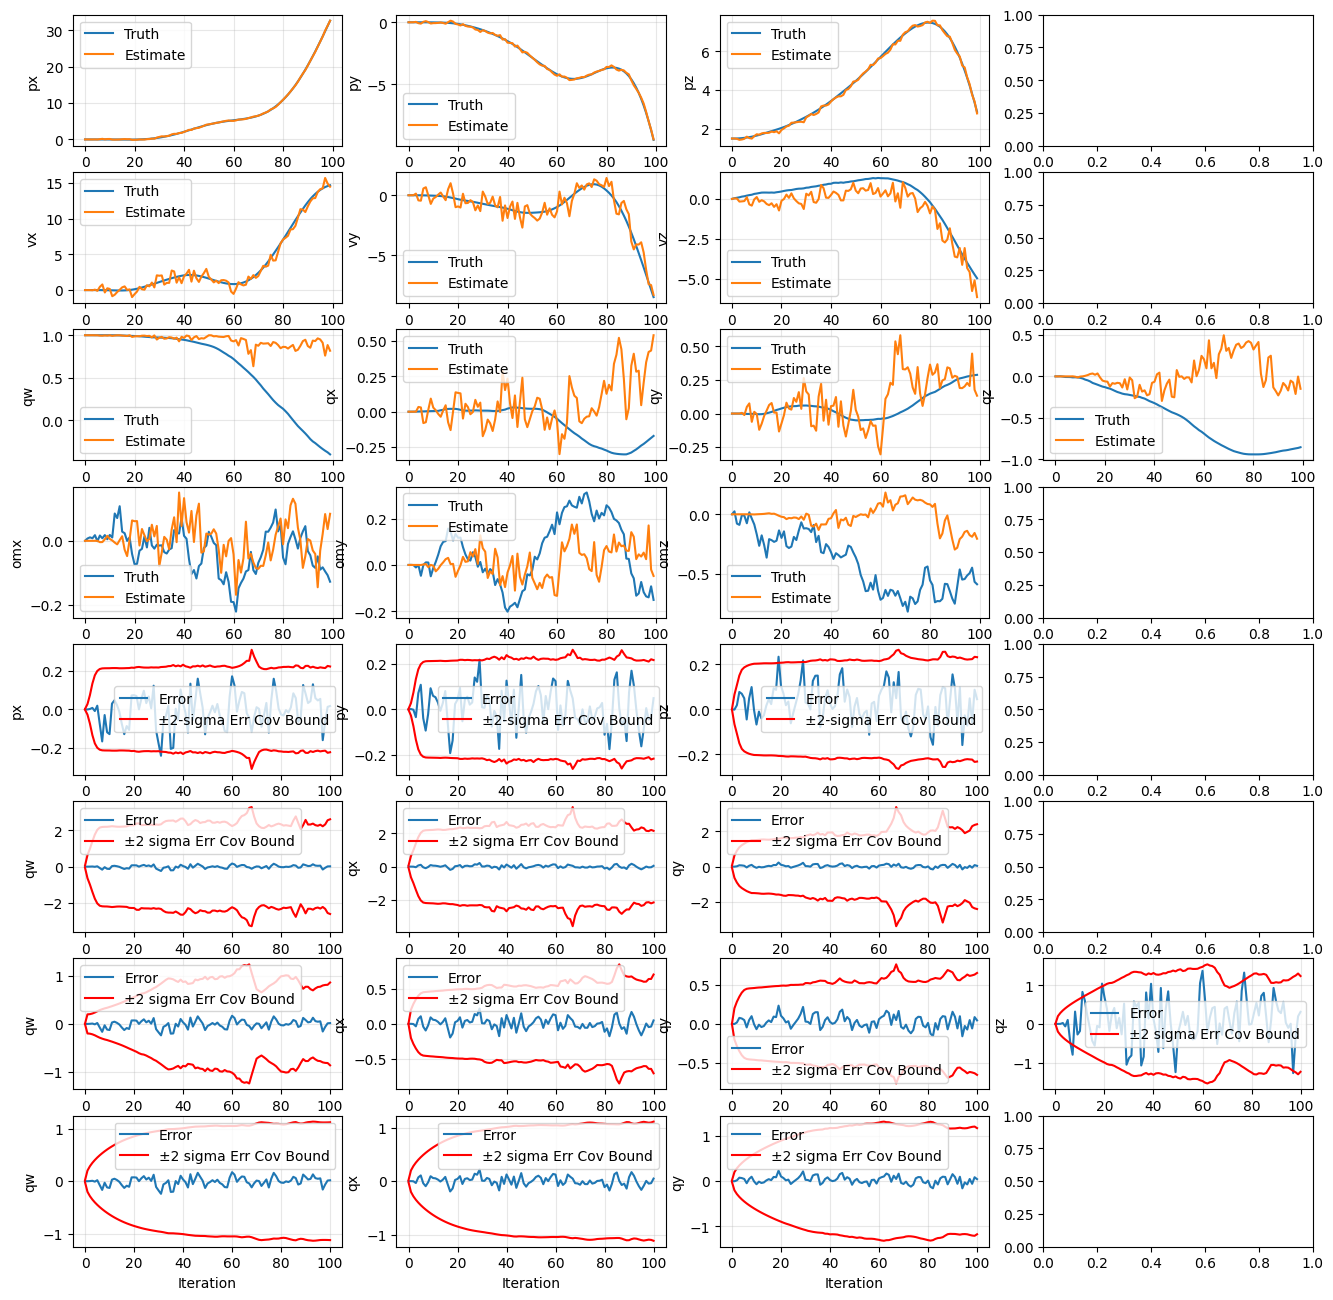

In [85]:
### Plotting code 
import matplotlib.pyplot as plt

xgt = np.array(quad.xh)
xhat = np.array(ukf.xhath)
xerr = xgt - xhat 
Qdiag = np.array([np.diag(Q) for Q in ukf.Qh])
sigma = 2 

fig, ax = plt.subplots(8, 4, figsize=(16, 16))
ylabels = ["px", "py", "pz", "vx", "vy", "vz", "qw", "qx", "qy", "qz", "omx", "omy", "omz"]

for i in range(3):
    ax[0][i].plot(xgt[:-1,i],label='Truth')
    ax[0][i].plot(xhat[:-1,i],label='Estimate')
    ax[0][i].set_xlabel('Iteration')
    ax[0][i].set_ylabel(ylabels[i])
    ax[0][i].legend()
    ax[0][i].grid(alpha=0.3)

for i in range(3):
    ax[1][i].plot(xgt[:-1,i+3],label='Truth')
    ax[1][i].plot(xhat[:-1,i+3],label='Estimate')
    ax[1][i].set_xlabel('Iteration')
    ax[1][i].set_ylabel(ylabels[i+3])
    ax[1][i].legend()
    ax[1][i].grid(alpha=0.3)

for i in range(4):
    ax[2][i].plot(xgt[:-1,i+6],label='Truth')
    ax[2][i].plot(xhat[:-1,i+6],label='Estimate')
    ax[2][i].set_xlabel('Iteration')
    ax[2][i].set_ylabel(ylabels[i+6])
    ax[2][i].legend()
    ax[2][i].grid(alpha=0.3)

for i in range(3):
    ax[3][i].plot(xgt[:-1,i+10],label='Truth')
    ax[3][i].plot(xhat[:-1,i+10],label='Estimate')
    ax[3][i].set_xlabel('Iteration')
    ax[3][i].set_ylabel(ylabels[i+10])
    ax[3][i].legend()
    ax[3][i].grid(alpha=0.3)
    
  
for i in range(3):
    ax[4][i].plot(xerr[:,i],label='Error')
    ax[4][i].plot( sigma*np.sqrt(Qdiag[:,i]), label=f'±{sigma}-sigma Err Cov Bound', color='r')
    ax[4][i].plot(-sigma*np.sqrt(Qdiag[:,i]), color='r')
    ax[4][i].set_xlabel('Iteration')
    ax[4][i].set_ylabel(ylabels[i])
    ax[4][i].legend()
    ax[4][i].grid(alpha=0.3)

for i in range(3):
    ax[5][i].plot(xerr[:,i],label='Error')
    ax[5][i].plot( sigma*np.sqrt(Qdiag[:,i+3]), label=f'±{sigma} sigma Err Cov Bound', color='r')
    ax[5][i].plot(-sigma*np.sqrt(Qdiag[:,i+3]), color='r')
    ax[5][i].set_xlabel('Iteration')
    ax[5][i].set_ylabel(ylabels[i+6])
    ax[5][i].legend()
    ax[5][i].grid(alpha=0.3)

for i in range(4):
    ax[6][i].plot(xerr[:,i],label='Error')
    ax[6][i].plot( sigma*np.sqrt(Qdiag[:,i+6]), label=f'±{sigma} sigma Err Cov Bound', color='r')
    ax[6][i].plot(-sigma*np.sqrt(Qdiag[:,i+6]), color='r')
    ax[6][i].set_xlabel('Iteration')
    ax[6][i].set_ylabel(ylabels[i+6])
    ax[6][i].legend()
    ax[6][i].grid(alpha=0.3)


for i in range(3):
    ax[7][i].plot(xerr[:,i],label='Error')
    ax[7][i].plot( sigma*np.sqrt(Qdiag[:,i+10]), label=f'±{sigma} sigma Err Cov Bound', color='r')
    ax[7][i].plot(-sigma*np.sqrt(Qdiag[:,i+10]), color='r')
    ax[7][i].set_xlabel('Iteration')
    ax[7][i].set_ylabel(ylabels[i+6])
    ax[7][i].legend()
    ax[7][i].grid(alpha=0.3)

### Example 2: Fly in a straight line 2. 

In this example the UKF measures position but it doesn't have access to the control law. 
Hence the orientation and angular rate predictions are worse (modeled as noise around the hover condition). 

In [86]:
# Simulate quad for a back and forth trajectory in x 
dt = 0.1
# time = np.arange(0, 10+dt, dt)
time = np.linspace(0, 10, int(10 / dt) )

# Initial conditions 
Q0 = np.diag([1e-6, 1e-6, 1e-6, 1e-3, 1e-3, 1e-3, 1e-5, 1e-5, 1e-5, 1e-5, 1e-4, 1e-4, 1e-4])
x0 = np.array([[0., 0., 1.5, 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,]]).T # p: 0, 0, 1.5; v: 0, 0, 0; q: 1, 0, 0, 0; omega: 0, 0, 0

# Initialize quad and ukf
quad = Quad(x0, dt)
ukf = UKF(quad, x0, Q0)

In [87]:
for t in time: 
    # Generate policy for simulation 
    u = policy(t)

    # Simulate quad
    # print(f"Shape of u: {u.shape}")
    quad.move(u)
    y_mes = quad.sense()

    # Run UKF 
    ukf.filter(y_mes, u, use_input=False)

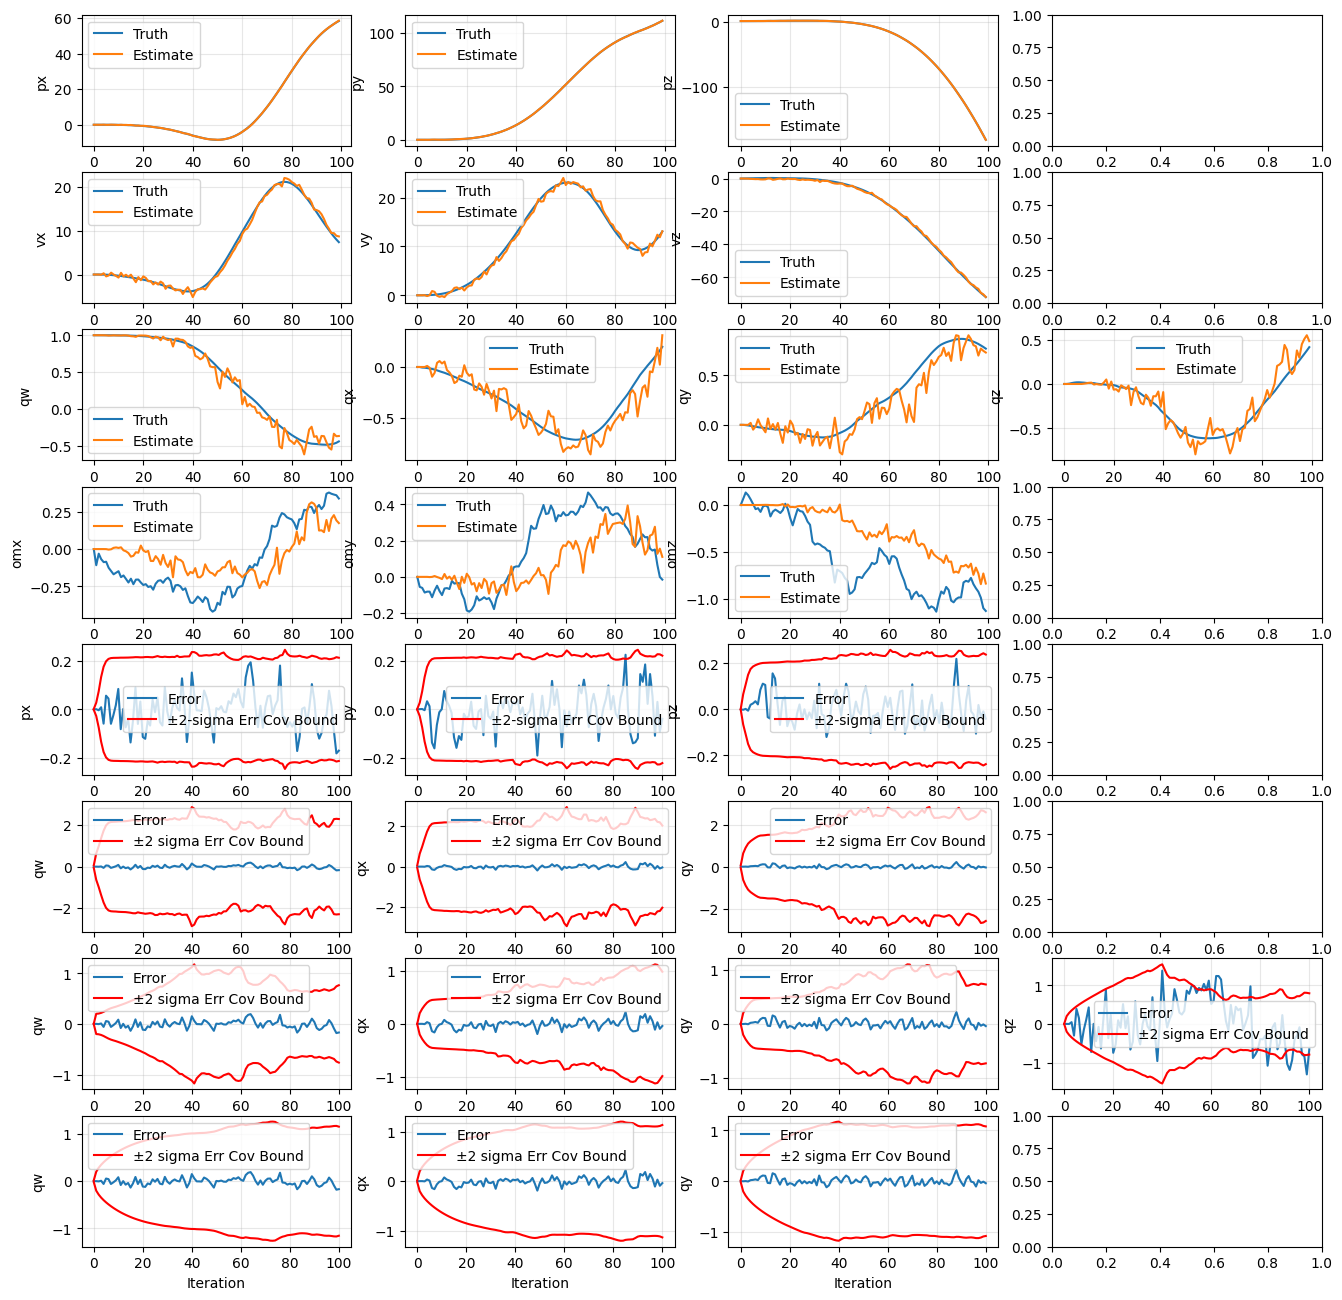

In [88]:
### Plotting code 
import matplotlib.pyplot as plt

xgt = np.array(quad.xh)
xhat = np.array(ukf.xhath)
xerr = xgt - xhat 
Qdiag = np.array([np.diag(Q) for Q in ukf.Qh])
sigma = 2 

fig, ax = plt.subplots(8, 4, figsize=(16, 16))
ylabels = ["px", "py", "pz", "vx", "vy", "vz", "qw", "qx", "qy", "qz", "omx", "omy", "omz"]

for i in range(3):
    ax[0][i].plot(xgt[:-1,i],label='Truth')
    ax[0][i].plot(xhat[:-1,i],label='Estimate')
    ax[0][i].set_xlabel('Iteration')
    ax[0][i].set_ylabel(ylabels[i])
    ax[0][i].legend()
    ax[0][i].grid(alpha=0.3)

for i in range(3):
    ax[1][i].plot(xgt[:-1,i+3],label='Truth')
    ax[1][i].plot(xhat[:-1,i+3],label='Estimate')
    ax[1][i].set_xlabel('Iteration')
    ax[1][i].set_ylabel(ylabels[i+3])
    ax[1][i].legend()
    ax[1][i].grid(alpha=0.3)

for i in range(4):
    ax[2][i].plot(xgt[:-1,i+6],label='Truth')
    ax[2][i].plot(xhat[:-1,i+6],label='Estimate')
    ax[2][i].set_xlabel('Iteration')
    ax[2][i].set_ylabel(ylabels[i+6])
    ax[2][i].legend()
    ax[2][i].grid(alpha=0.3)

for i in range(3):
    ax[3][i].plot(xgt[:-1,i+10],label='Truth')
    ax[3][i].plot(xhat[:-1,i+10],label='Estimate')
    ax[3][i].set_xlabel('Iteration')
    ax[3][i].set_ylabel(ylabels[i+10])
    ax[3][i].legend()
    ax[3][i].grid(alpha=0.3)
    
for i in range(3):
    ax[4][i].plot(xerr[:,i],label='Error')
    ax[4][i].plot( sigma*np.sqrt(Qdiag[:,i]), label=f'±{sigma}-sigma Err Cov Bound', color='r')
    ax[4][i].plot(-sigma*np.sqrt(Qdiag[:,i]), color='r')
    ax[4][i].set_xlabel('Iteration')
    ax[4][i].set_ylabel(ylabels[i])
    ax[4][i].legend()
    ax[4][i].grid(alpha=0.3)

for i in range(3):
    ax[5][i].plot(xerr[:,i],label='Error')
    ax[5][i].plot( sigma*np.sqrt(Qdiag[:,i+3]), label=f'±{sigma} sigma Err Cov Bound', color='r')
    ax[5][i].plot(-sigma*np.sqrt(Qdiag[:,i+3]), color='r')
    ax[5][i].set_xlabel('Iteration')
    ax[5][i].set_ylabel(ylabels[i+6])
    ax[5][i].legend()
    ax[5][i].grid(alpha=0.3)

for i in range(4):
    ax[6][i].plot(xerr[:,i],label='Error')
    ax[6][i].plot( sigma*np.sqrt(Qdiag[:,i+6]), label=f'±{sigma} sigma Err Cov Bound', color='r')
    ax[6][i].plot(-sigma*np.sqrt(Qdiag[:,i+6]), color='r')
    ax[6][i].set_xlabel('Iteration')
    ax[6][i].set_ylabel(ylabels[i+6])
    ax[6][i].legend()
    ax[6][i].grid(alpha=0.3)


for i in range(3):
    ax[7][i].plot(xerr[:,i],label='Error')
    ax[7][i].plot( sigma*np.sqrt(Qdiag[:,i+10]), label=f'±{sigma} sigma Err Cov Bound', color='r')
    ax[7][i].plot(-sigma*np.sqrt(Qdiag[:,i+10]), color='r')
    ax[7][i].set_xlabel('Iteration')
    ax[7][i].set_ylabel(ylabels[i+6])
    ax[7][i].legend()
    ax[7][i].grid(alpha=0.3)